# Preamble 

This lab uses the climlab package https://climlab.readthedocs.io/en/latest/ by Brian Rose at the Unviersity of Albany.

This follows on closely from lab 3, but with a new function that you can use.

The function getEquilRadConvColumn will setup and run the model for your, you can see the default arguements that it takes and modify them accordingly when you call the function.

The function makePlotsFromExperimentList will make some plots of the vertical profiles of temperature, moisture, radiative fluxes and heating rates, given a list of experiments. 

The function getRadDiagnostic will take in input values of surface temperature, atmospheric temperature, and moisture, and will rerun the radiation code and output the radiation diagnostics.

Some examples of how to use these two functions are shown below.

In [1]:
import climlab
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import scipy as sp
import xarray as xr

In [2]:
def getEquilRadConvColumn(
        return_model=False,
        num_lev=20,
        relHum=0.8,
        lapseRate=6,
        integrate_years=5,
        water_depth=5.,
        do_conv=True,
        albedo=0.3,
        CO2=0.000348,
        CH4=1.65e-06,
        N2O=3.06e-07,
        O2=0.21,
        CFC11=0.0,
        CFC12=0.0,
        CFC22=0.0,
        CCL4=0.0,
        O3_profile=np.array([5.38853507e-06, 9.86362297e-07, 3.46334801e-07, 1.90806332e-07,
                                    1.19700066e-07, 7.69083554e-08, 5.97316411e-08, 5.27011190e-08,
                                    4.80406196e-08, 4.44967931e-08, 4.18202246e-08, 3.99595858e-08,
                                    3.83838549e-08, 3.66179869e-08, 3.42885526e-08, 3.18505117e-08,
                                    2.93003951e-08, 2.69906527e-08, 2.49122466e-08, 2.28798533e-08]),
        O3fac=1.0,
        insolation=341.,
        cldfrac=0., 
        clwp=0., 
        ciwp = 0.,
        r_liq = 0.,
        r_ice = 0.,
        ):
    
    '''
    Mostly used as an interface to make it easy to 
    remember what the default GHGs are and change them
    '''

    # get the different components of the model
    # state - container for the vertical temperature profile
    # water vapour - set moisture based on relative humidity profile        
    # convection - hard convective adjustment
    # radiation - RRTM spectral radiation 

    state = climlab.column_state(num_lev=num_lev,
                                 num_lat=1,
                                 water_depth=water_depth)

    water_vapor = climlab.radiation.water_vapor.ManabeWaterVapor(state=state,
                                                                        name='Constant Relative Humidity')

    # water_vapor = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
    #                                                                     relative_humidity=relHum,
    #                                                                     name='Constant Relative Humidity')
    
    state['q'] = water_vapor.q

    if do_conv:
        convection = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                                  state=state,
                                                  adj_lapse_rate=lapseRate)    

    # create the ghg dict
    ghgDict = {'CO2': CO2,
                'CH4': CH4,
                'N2O': N2O,
                'O2': O2,
                'CFC11': CFC11,
                'CFC12': CFC12,
                'CFC22': CFC22,
                'CCL4': CCL4,
                'O3': O3fac*O3_profile}

    radiation = climlab.radiation.CAM3(name='Radiation',
                             state=state,
                             specific_humidity=water_vapor.q,
                             absorber_vmr=ghgDict,
                             cldfrac=cldfrac,
                             clwp=clwp,
                             ciwp=ciwp,
                             r_liq=r_liq,
                             r_ice=r_ice,
                             insolation=insolation,
                             return_spectral_olr=True,
                             albedo=albedo)

    # combine the components of the model together 
    if do_conv:
        model = climlab.couple([radiation,convection,water_vapor], name='RadConv')
    else:
        model = climlab.couple([radiation,water_vapor], name='RadOnly')

    # actually run the model 
    model.integrate_converge()
    model.compute_diagnostics()
    # print(model.OLR_spectral)

    if return_model:
        return model
    else:
        return model.to_xarray(diagnostics=True)

In [14]:
def getRadDiagnostic(
        input_state_Ts,
        input_state_Tatm,
        input_state_q,
        relHum=0.8,
        CO2=0.000348,
        CH4=1.65e-06,
        N2O=3.06e-07,
        O2=0.21,
        CFC11=0.0,
        CFC12=0.0,
        CFC22=0.0,
        CCL4=0.0,
        O3_profile=np.array([5.38853507e-06, 9.86362297e-07, 3.46334801e-07, 1.90806332e-07,
                                    1.19700066e-07, 7.69083554e-08, 5.97316411e-08, 5.27011190e-08,
                                    4.80406196e-08, 4.44967931e-08, 4.18202246e-08, 3.99595858e-08,
                                    3.83838549e-08, 3.66179869e-08, 3.42885526e-08, 3.18505117e-08,
                                    2.93003951e-08, 2.69906527e-08, 2.49122466e-08, 2.28798533e-08]),
        O3fac=1.0,
        insolation=341.,
        cldfrac=0., 
        clwp=0., 
        ciwp = 0.,
        r_liq = 0.,
        r_ice = 0.,
        albedo=0.1,
        ):

    # get the different components of the model
    # state - container for the vertical temperature profile
    # water vapour - set moisture based on relative humidity profile        
    # radiation - RRTM spectral radiation 

    # create the ghg dict
    ghgDict = {'CO2': CO2,
                'CH4': CH4,
                'N2O': N2O,
                'O2': O2,
                'CFC11': CFC11,
                'CFC12': CFC12,
                'CFC22': CFC22,
                'CCL4': CCL4,
                'O3': O3fac*O3_profile}

    # this is necessary because we output the states to xarray,
    # so have to convert back to state.    
    state = climlab.column_state(num_lev=len(input_state_Tatm), num_lat=1)
    state['Ts'][:] = input_state_Ts
    state['Tatm'][:] = input_state_Tatm

    water_vapor = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                                        relative_humidity=relHum)
    
#    water_vapor.q = input_state_q
    
#    print(water_vapor.q)

    radiation = climlab.radiation.CAM3(name='Radiation',
                             state=state,
                             specific_humidity=input_state_q,
#                             specific_humidity=water_vapor.q,
                             absorber_vmr=ghgDict,
                             cldfrac=cldfrac,
                             clwp=clwp,
                             ciwp=ciwp,
                             r_liq=r_liq,
                             r_ice=r_ice,
                             insolation=insolation,
                             albedo=albedo)
    
#    state['q'] = input_state_q

    radiation.compute_diagnostics()

    # output the data as an xarray dataset
    return radiation.to_xarray(diagnostics=True)



In [15]:
def getRadLWDiagnostics(
        input_state_Ts,
        input_state_Tatm,
        input_state_q,
        relHum=0.8,
        CO2=0.000348,
        CH4=1.65e-06,
        N2O=3.06e-07,
        O2=0.21,
        CFC11=0.0,
        CFC12=0.0,
        CFC22=0.0,
        CCL4=0.0,
        O3_profile=np.array([5.38853507e-06, 9.86362297e-07, 3.46334801e-07, 1.90806332e-07,
                                    1.19700066e-07, 7.69083554e-08, 5.97316411e-08, 5.27011190e-08,
                                    4.80406196e-08, 4.44967931e-08, 4.18202246e-08, 3.99595858e-08,
                                    3.83838549e-08, 3.66179869e-08, 3.42885526e-08, 3.18505117e-08,
                                    2.93003951e-08, 2.69906527e-08, 2.49122466e-08, 2.28798533e-08]),
        O3fac=1.0,
        insolation=341.,
        cldfrac=0., 
        clwp=0., 
        ciwp = 0.,
        r_liq = 0.,
        r_ice = 0.,
        albedo=0.1,
        ):

    # get the different components of the model
    # state - container for the vertical temperature profile
    # water vapour - set moisture based on relative humidity profile        
    # radiation - RRTM spectral radiation 

    # create the ghg dict
    ghgDict = {'CO2': CO2,
                'CH4': CH4,
                'N2O': N2O,
                'O2': O2,
                'CFC11': CFC11,
                'CFC12': CFC12,
                'CFC22': CFC22,
                'CCL4': CCL4,
                'O3': O3fac*O3_profile}

    # this is necessary because we output the states to xarray,
    # so have to convert back to state.    
    state = climlab.column_state(num_lev=len(input_state_Tatm), num_lat=1)
    state['Ts'][:] = input_state_Ts
    state['Tatm'][:] = input_state_Tatm

    water_vapor = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                                        relative_humidity=relHum)
    
#    water_vapor.q = input_state_q
    
#    print(water_vapor.q)

    radiation = climlab.radiation.CAM3(name='Radiation',
                             state=state,
                             specific_humidity=input_state_q,
#                             specific_humidity=water_vapor.q,
                             absorber_vmr=ghgDict,
                             cldfrac=cldfrac,
                             clwp=clwp,
                             ciwp=ciwp,
                             r_liq=r_liq,
                             r_ice=r_ice,
                             insolation=insolation,
                             return_spectral_olr=True,
                             albedo=albedo)
    
#    state['q'] = input_state_q

    radiation.compute_diagnostics()

    # output the data as an xarray dataset
    return radiation.to_xarray(diagnostics=True)



In [16]:
def makePlotsFromExperimentList(rl,labell,
colorlist=['black','blue','red','green','orange','purple'],
plotDiff=False,
outputname=None,
suptitle='TITLE GOES HERE'
):

    titles=['T (K)','q(kg/kg)','','SW Flux (W/m^2)','LW Flux (W/m^2)','Heating Rates (K/day)']

    fig,axs=plt.subplots(2,3,figsize=(12,10),dpi=100)

    fig.delaxes(axs[0,-1])

    nl=range(0,len(rl))

    for n,r,l,c in zip(nl,rl,labell,colorlist):

        if plotDiff:
            r=r-rl[0]

        # temperature
        axs[0,0].plot(r.Tatm,r.lev,
                    label=l,color=c)

        # moisture
        axs[0,1].plot(r.q,r.lev,
                      label=l,color=c)

        if n==0:
            label0='FluxUp'
            label1='FluxDown'
            label2='FluxNet'
        else:
            label0=None
            label1=None
            label2=None
 
        # shortwave
        axs[1,0].plot(r.SW_flux_up,r.lev_bounds,
                      label=label0,color=c,linestyle='--')
        axs[1,0].plot(r.SW_flux_down,r.lev_bounds,
                      label=label1,color=c,linestyle='-.')
        axs[1,0].plot(r.SW_flux_net,r.lev_bounds,
                      label=label2,color=c,linestyle='-')
        
        # longwave
        axs[1,1].plot(r.LW_flux_up,r.lev_bounds,
                      label=label0,color=c,linestyle='--')
        axs[1,1].plot(r.LW_flux_down,r.lev_bounds,
                      label=label1,color=c,linestyle='-.')
        axs[1,1].plot(r.LW_flux_net,r.lev_bounds,
                      label=label2,color=c,linestyle='-')
        
        if n==0:
            label0='SW'
            label1='LW'
        else:
            label0=None
            label1=None

        # heating rates
        axs[1,2].plot(r.TdotSW,r.lev,
                        color=c,label=label0,linestyle='--')
        axs[1,2].plot(r.TdotLW,r.lev,
                        color=c,label=label1,linestyle='-.')

    for i,j in product(range(0,2),range(0,3)):
        axs[i,j].set_ylim([1e3,0])
        axs[i,j].set_title(titles[3*i+j])
        axs[i,j].set_ylabel('p (hPa)')

    axs[0,0].legend()
    axs[1,0].legend()
    axs[1,-1].legend()

    fig.suptitle(suptitle)
    fig.tight_layout()

    if not outputname is None:
        plt.savefig(outputname)

    plt.show()

# Example 3 - Calculating radiative diagnostics

In [17]:
# compute the model solutions for a radiative column 
ds=getEquilRadConvColumn()

Total elapsed time is 7.994695027025902 years.


In [18]:
# note - for some reason climlab needs to get numpy arrays and not datasets to initialize
# if you try passing the data in as xarray as xarray objects it will throw an error at you.
ds_rad = getRadDiagnostic(ds.Ts.data, ds.Tatm.data, ds.q.data)

# lets check and see that the diagnostics worked
# since we passed the profiles from the equillibrium state back to the diagnostic function it should give us 0.
print(ds_rad.OLR.data - ds.OLR.data)

[0.]



# Questions {-}

## 1. Perturbing the model {-}

For the next two sub-questions we are going to consider perturbing the model in the following ways:

1. doubling the CO2
2. doubling the O3
3. doubling the CH4
4. halfing the albedo 

### 1.1 perturbing in the radiative only model {-}

- run each perturbation with the convection off and make a plot.

- What does each perturbation do to the vertical structure of the temperature perturbation, and why?

- What is different about the albedo simulation compared to the others? (hint: look at the SW and LW plots).

### 1.2 perturbing in the radiative-convective model {-}

- run each perturbation with the convection off and make a plot.

- How does the vertical structure of the temperature perturbations compare to the model without convection?

### 2 CO2 doubling while variyng the lapse rate {-}

- run the doubled CO2 expeirment but now while varying the lapse rate between 3, 6, and 9 K/km.

- What is happening to the vertical structure of convection under the CO2 doubling, and how is this affected by the change in lapse rate?

- how does the vertical structure of the temperature and humidity responses to CO2 doubling vary with lapse rate? 

### 3 Making your own Radiative Kernel (sort of) {-}

- Run the model to equillibrium with a lapse rate of 3K/km (or use the data from a pervious run). Using the function getEquilRadConvColumn(), change the air temperature by 1K in each layer from the lowest layer to 200 hPa and calculate the new OLR. Take the difference between OLR calculated with and without the perturbation to find the temperature kernel at that level $$ K^p_T = OLR(T_a(p)+1K) - OLR(T_a(p)) $$

- Repeat the above calculations but with a lapse rate of 9K/km.

- Plot $K_T$ for both calculations. Why do you think that there is a difference in the upper troposphere?


# Answers {-}

## 1. Perturbing the model {-}

For the next two sub-questions we are going to consider perturbing the model in the following ways:

1. doubling the CO2
2. doubling the O3
3. doubling the CH4
4. halfing the albedo 

### 1.1 perturbing in the radiative only model {-}

- See the first plot

- CO2 makes very little change, because the stratospheric cooling offsets the tropospheric warming. CH4 only changes the tropospheric temperatures, which warm. O3 makes a large change in the stratosphere and upper troposphere because it is located in the stratosphere. The albedo change makes a large difference in the lower troposphere because it allows more shortwave to be absorbed at the surface. 

- The GHGs change the longwave effect (primarily), the albedo changes the shortwave.

### 1.2 perturbing in the radiative-convective model {-}

- See the second plot.

- Compared to the radiation only model the vertical temperature perturbations are much more vertically uniform. This is because the convection is mixing the temperature change singles throughout the troposphere.

### 2 CO2 doubling while variyng the lapse rate {-}

- See the third plot.

- The change in convective heating is negative in the lower troposphere, and positive in the upper troposphere. This indicates that convection is shifting to higher vertical levels.

- When the lapse rate is high, there are large changes at the surface, and small changes aloft in the temperature. When the lapse rate is high, the temperature response is much more vertically uniform. Upper tropospheric water vapor only changes when the lapse rate is small, but the changes at the surface are large for all of the lapse rate values.

### 3 Making your own Radiative Kernel (sort of) {-}

- See the fourth plot.

- For the lower lapse rate calculation $K_T$ is larger in the upper troposphere. For the higher lapse rate $K_T$ has a local maximum in the lower troposhere. The difference between the two is explained by the differences in upper tropospheric water vapor. In the low lapse rate case, the radiation coming from near the surface is mostly absorbed in the upper atmosphere, and so the OLR is relatively insensitive to changes in the temperature changes in the lower troposphere. In the high lapse rate case, there water vapor in the upper troposphere is low enough that the emissivity is lower, so increasing the temperature there does not change OLR much. By contrast, in the lower troposphere temperature perturbations can significantly change the OLR because it can all travel directly to space.

In [19]:
ds_co2=getEquilRadConvColumn(CO2=0.000348*2)
ds_ch4=getEquilRadConvColumn(CH4=1.65e-6*2)
ds_o3=getEquilRadConvColumn(O3fac=2)
ds_alb=getEquilRadConvColumn(albedo=0.15)

Total elapsed time is 7.994695027025902 years.
Total elapsed time is 7.994695027025902 years.
Total elapsed time is 7.994695027025902 years.
Total elapsed time is 7.994695027025902 years.


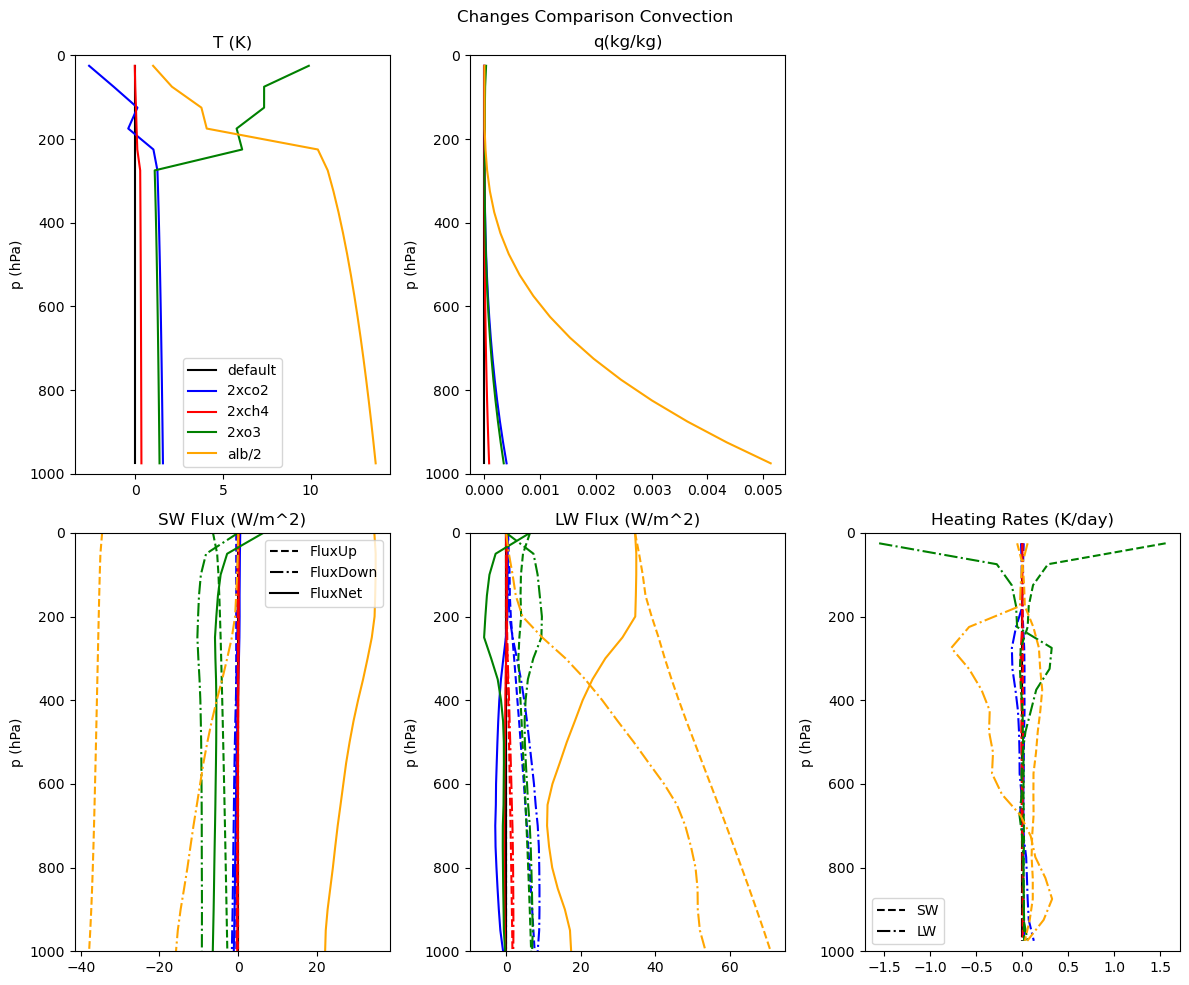

In [21]:
makePlotsFromExperimentList([ds,ds_co2,ds_ch4,ds_o3,ds_alb],['default','2xco2','2xch4','2xo3','alb/2'],plotDiff=True,suptitle='Changes Comparison Convection')

In [27]:
ds_nc=getEquilRadConvColumn(do_conv=False)
ds_nc_co2=getEquilRadConvColumn(CO2=0.000348*2,do_conv=False)
ds_nc_ch4=getEquilRadConvColumn(CH4=1.65e-6*2,do_conv=False)
ds_nc_o3=getEquilRadConvColumn(O3fac=2,do_conv=False)
ds_nc_alb=getEquilRadConvColumn(albedo=0.15,do_conv=False)

Total elapsed time is 8.994031905404139 years.
Total elapsed time is 8.994031905404139 years.
Total elapsed time is 8.994031905404139 years.
Total elapsed time is 8.994031905404139 years.
Total elapsed time is 7.994695027025902 years.


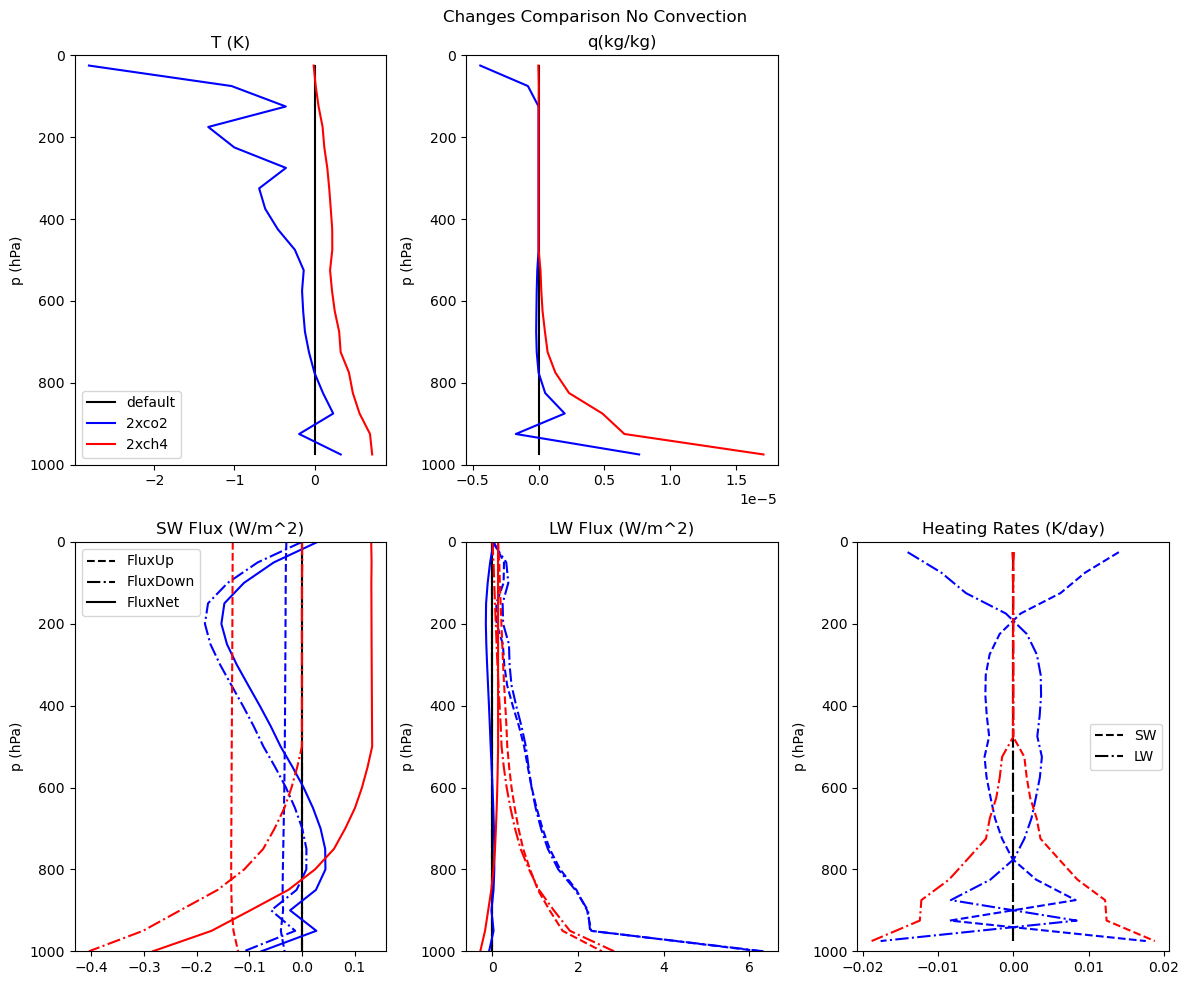

In [30]:
makePlotsFromExperimentList([ds_nc,ds_nc_co2,ds_nc_ch4,],#ds_nc_o3,ds_nc_alb],
                                  ['default','2xco2','2xch4','2xo3','alb/2'],
                                  plotDiff=True,
                                  suptitle='Changes Comparison No Convection')

In [20]:
ds_2x = ds_co2#getEquilRadConvColumn(lapseRate=6,CO2=0.00348*2)
ds_2x_3 = getEquilRadConvColumn(lapseRate=3,CO2=0.00348*2)
ds_2x_9 = getEquilRadConvColumn(lapseRate=9,CO2=0.00348*2)

Total elapsed time is 6.995358148647664 years.
Total elapsed time is 5.996021270269426 years.


In [12]:
makePlotsFromExperimentListEdited([ds_2x-ds,ds_2x_3-ds_3,ds_2x_9-ds_9],['LR=6','LR=3','LR=9'],
                                  suptitle='Effects of Lapse Rate on 2x Changes')

NameError: name 'makePlotsFromExperimentListEdited' is not defined

In [161]:
ds_3 = getEquilRadConvColumn(lapseRate=3)
ds_9 = getEquilRadConvColumn(lapseRate=9)

OLR0_3 = getRadDiagnostic(ds_3.Ts.data,ds_3.Tatm.data, ds_3.q.data).OLR
OLR0_9 = getRadDiagnostic(ds_9.Ts.data,ds_9.Tatm.data, ds_9.q.data).OLR
K_3 = np.zeros(20)
K_9 = np.zeros(20)
for i in range(4,20):
    pert = np.zeros(20)
    pert[i] = 1
    OLR1_3 = getRadDiagnostic(ds_3.Ts.data, ds_3.Tatm.data+pert, ds_3.q.data).OLR
    K_3[i] = OLR1_3 - OLR0_3
    OLR1_9 = getRadDiagnostic(ds_9.Ts.data, ds_9.Tatm.data+pert, ds_9.q.data).OLR
    K_9[i] = OLR1_9 - OLR0_9

Total elapsed time is 7.994695027025902 years.
Total elapsed time is 7.994695027025902 years.


(1000.0, 0.0)

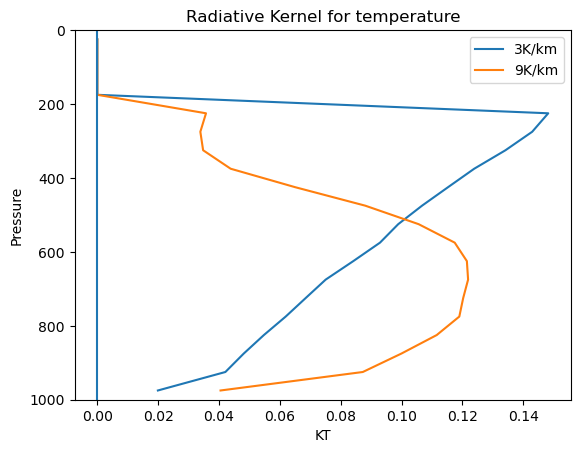

In [162]:
plt.title('Radiative Kernel for temperature')
plt.plot(K_3,ds.lev,label = '3K/km')
plt.plot(K_9,ds.lev, label = '9K/km')
plt.legend()
plt.ylabel('Pressure')
plt.xlabel('KT')
plt.axvline(0)
plt.ylim([1e3,0])